In [8]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"./flights.csv")
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [3]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


In [4]:
airports = pd.read_csv(r"./airports.csv")

In [6]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [9]:
df = df[df['MONTH'] == 1]

In [10]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [15]:
def format_heure (chain):
    if pd.isnull(chain):
        return np.nan
    else:
        if chain == 2400: chain = 0
        chain = "{0:04d}".format(int(chain))
        heure = datetime.time(int(chain[0:2]), int(chain[2:4]))
        return heure

In [16]:
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [17]:
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [18]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)

In [19]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [20]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [21]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [22]:
df.dropna()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0
5,DL,SFO,MSP,2015-01-01 00:25:00,00:20:00,-5.0,06:02:00,06:10:00,8.0,217.0,230.0
6,NK,LAS,MSP,2015-01-01 00:25:00,00:19:00,-6.0,05:26:00,05:09:00,-17.0,181.0,170.0
7,US,LAX,CLT,2015-01-01 00:30:00,00:44:00,14.0,08:03:00,07:53:00,-10.0,273.0,249.0
8,AA,SFO,DFW,2015-01-01 00:30:00,00:19:00,-11.0,05:45:00,05:32:00,-13.0,195.0,193.0
9,DL,LAS,ATL,2015-01-01 00:30:00,00:33:00,3.0,07:11:00,06:56:00,-15.0,221.0,203.0


In [23]:
airlines_names = pd.read_csv(r"./airlines.csv")
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [24]:

abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()


In [25]:
# __________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats




,count,max,mean,min
AIRLINE,,,,
VX,4651.0,397.0,6.910772,-20.0
HA,6418.0,1003.0,1.310065,-26.0
F9,6745.0,696.0,17.984433,-32.0
NK,8647.0,557.0,13.146294,-28.0
AS,13198.0,538.0,3.178209,-47.0
B6,20531.0,500.0,10.035556,-27.0
MQ,27670.0,780.0,16.081207,-29.0
US,32552.0,638.0,5.197315,-26.0
UA,37454.0,886.0,14.010359,-40.0


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


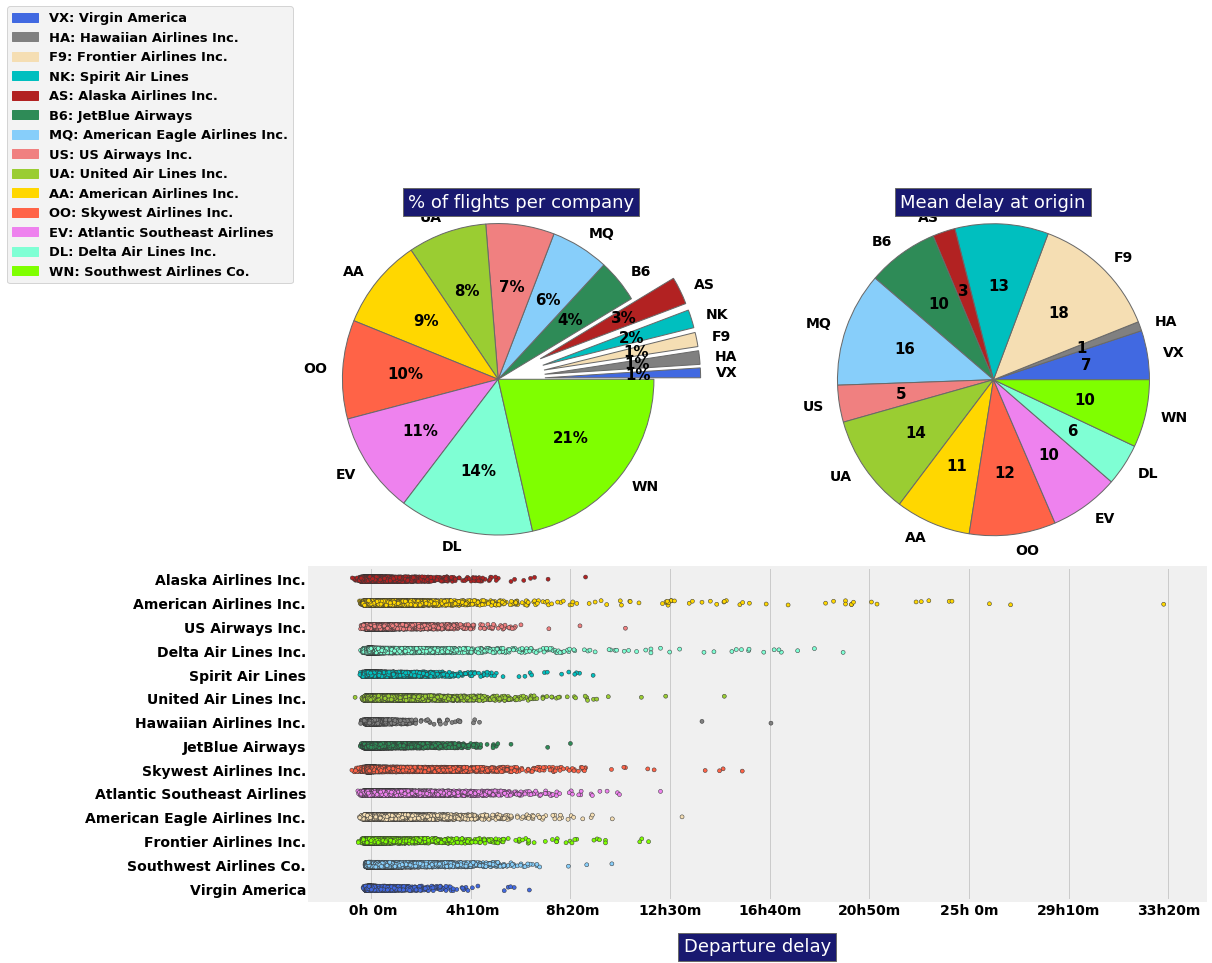

In [26]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 




findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


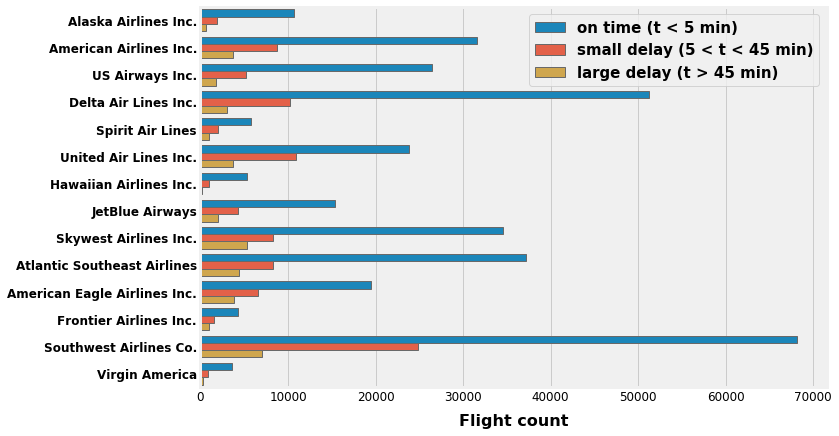

In [27]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()




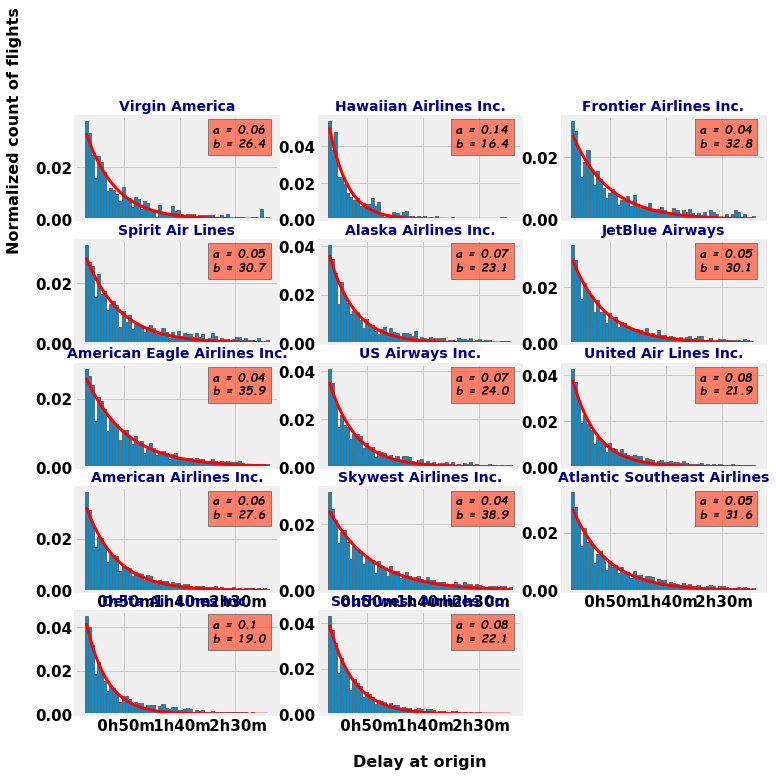

In [28]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()




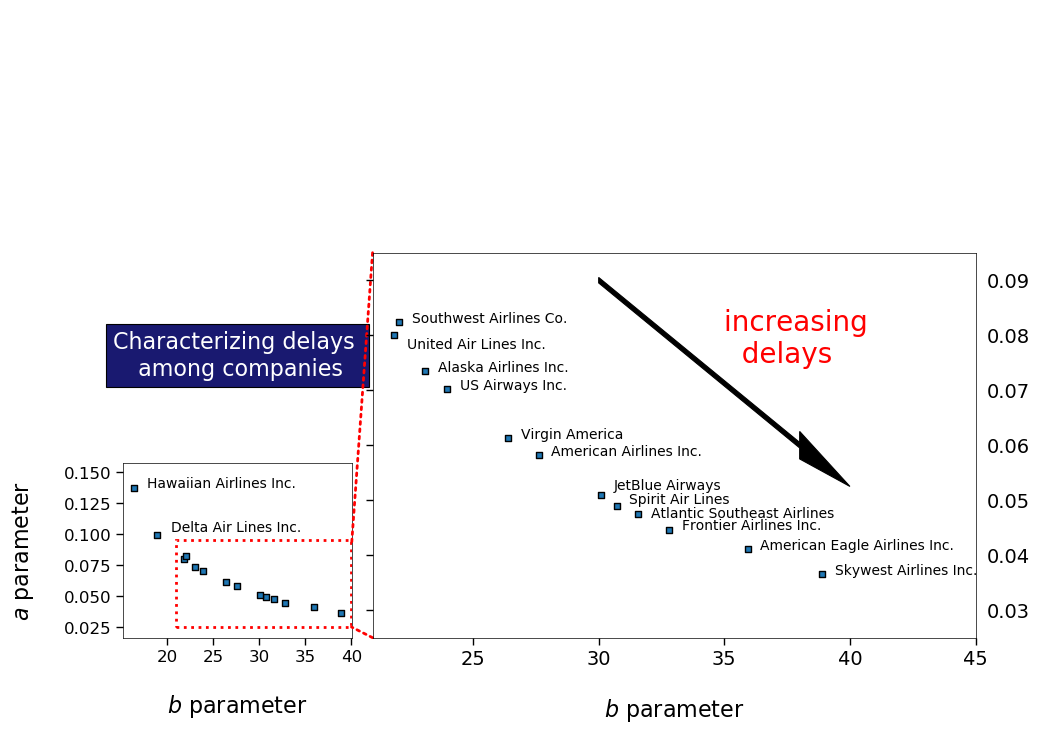

In [29]:

mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()



In [30]:

print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))


Nb of airports: 312


In [31]:

origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)



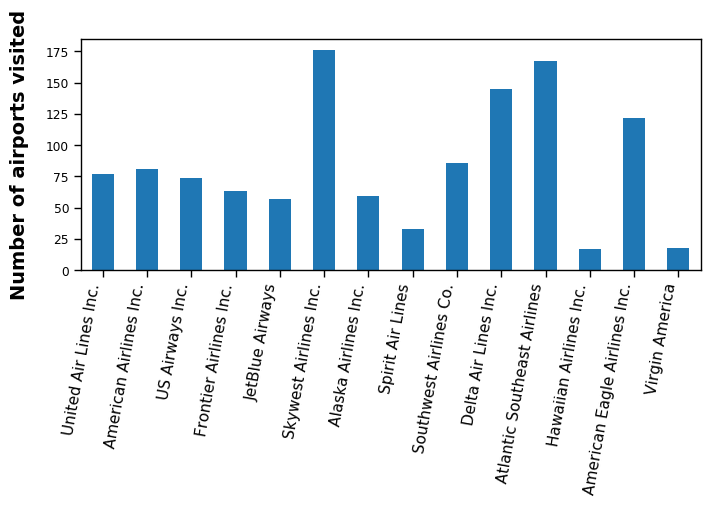

In [32]:

test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()




In [33]:

temp = pd.read_csv(r"./airports.csv")
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()



In [34]:


def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(7,3))
    ax=fig.add_axes([0.,0.,1.,1.])
    m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,
                  llcrnrlat=lat_min, urcrnrlat=lat_max, lat_0=0, lon_0=0,)
    df2 = df[df['AIRLINE'] == carrier]
    count_trajectories = df2.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
                   color = 'seagreen', markeredgecolor='k')

    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or                 pd.isnull(lonlat) or pd.isnull(lonlon): continue
        if s < 100:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
        elif s < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
    #_____________________________________________
    # remove duplicate labels and set their order
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)    
    m.drawcoastlines()
    m.fillcontinents()
    ax.set_title('{} flights'.format(abbr_companies[carrier]))



NameError: name 'Basemap' is not defined

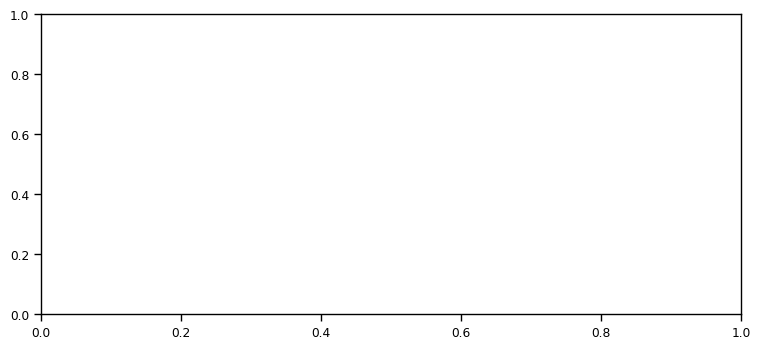

In [35]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA', 'AS', 'HA']: 
    make_map(df, carrier, *coord[carrier])



In [36]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']



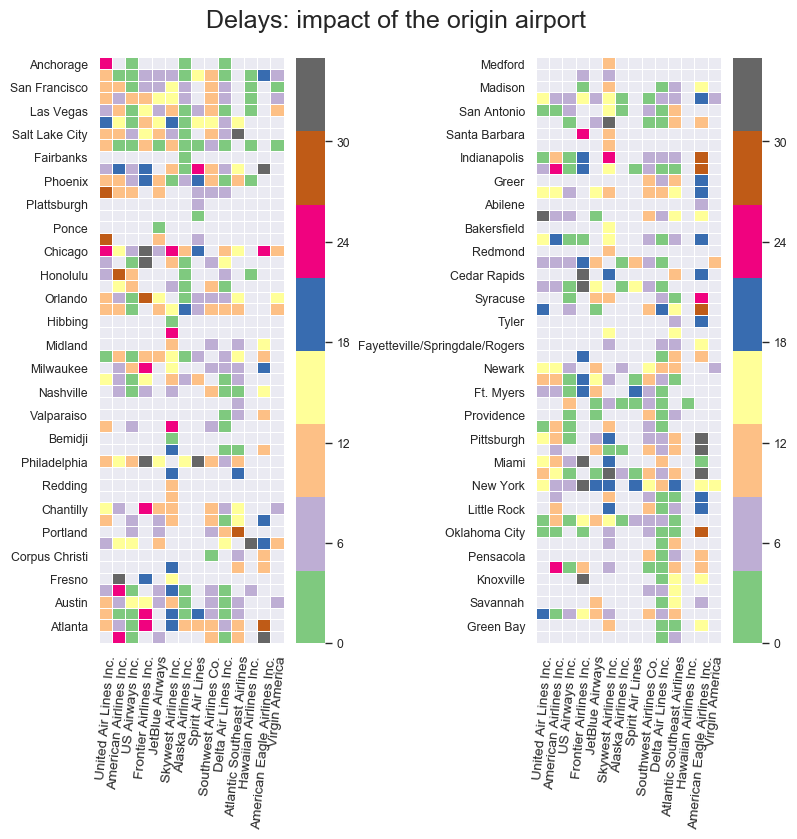

In [37]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()




In [38]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()




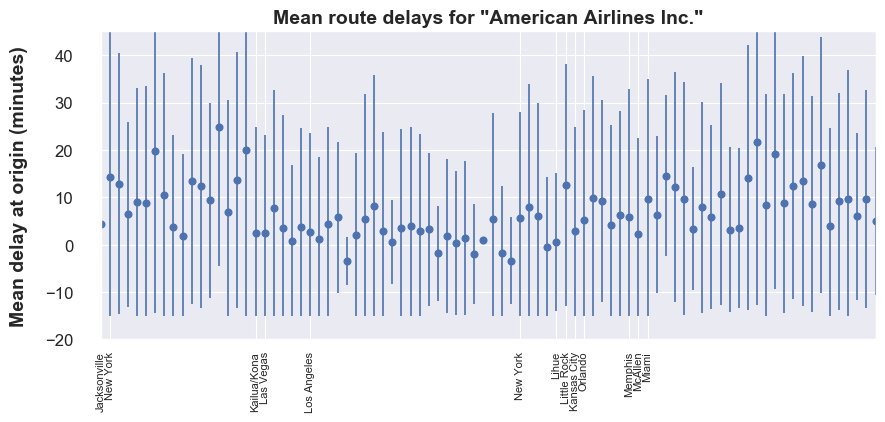

In [39]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()



In [40]:

#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()


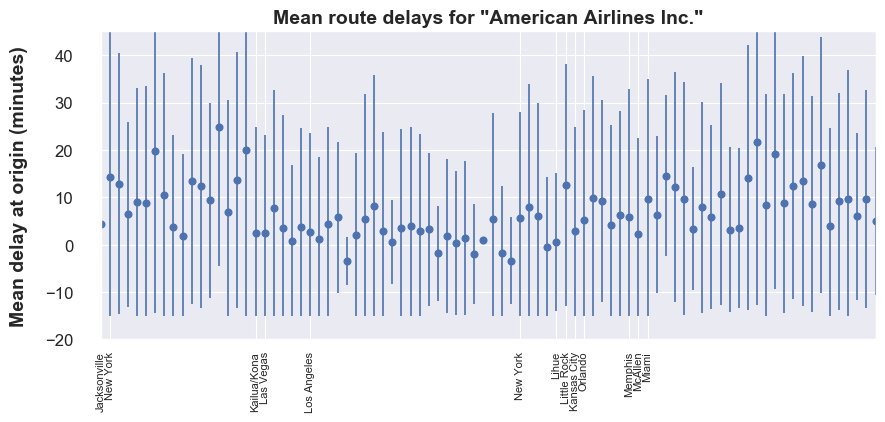

In [41]:


mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()



In [42]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])           




In [43]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)


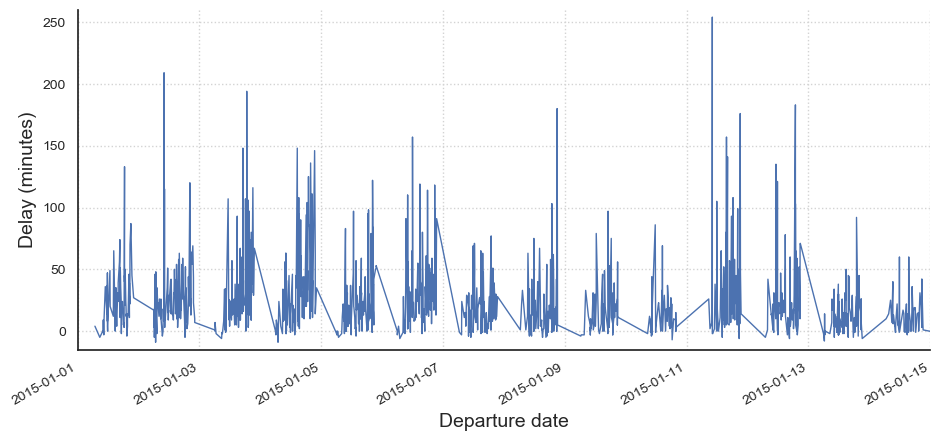

In [44]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)



In [45]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)



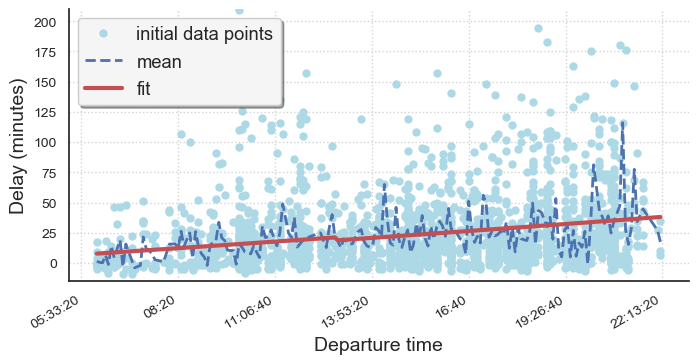

In [46]:


fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot_date(df2['heure_depart'], df2['DEPARTURE_DELAY'],
                    markeredge=False, label='initial data points')
fig1.cust_plot(test2.index, test2['mean'], linestyle='--', linewidth=2, label='mean')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')
fig1.style() ; fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
fig1.set_ylim(-15, 210)



In [47]:

df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train


In [48]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]


,count,max,mean,min
ORIGIN_AIRPORT,,,,
JAC,25.0,47.0,-3.640000,-19.0
GUC,22.0,199.0,13.227273,-24.0
SDF,19.0,55.0,8.421053,-8.0
LIT,9.0,74.0,12.555556,-5.0
MTJ,3.0,51.0,26.000000,-2.0


In [49]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2



In [51]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result



In [52]:
id_airport = 'PHL'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)



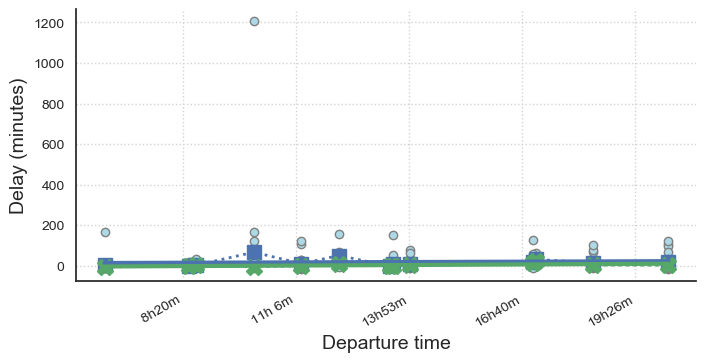

In [53]:

fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);




In [54]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test =                 train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)



modèle nº1 , min. pour n = 1, score = 65.4
modèle nº2 , min. pour n = 1, score = 24.7
modèle nº3 , min. pour n = 3, score = 12.5
modèle nº4 , min. pour n = 1, score = 55.3
modèle nº5 , min. pour n = 2, score = 158.4


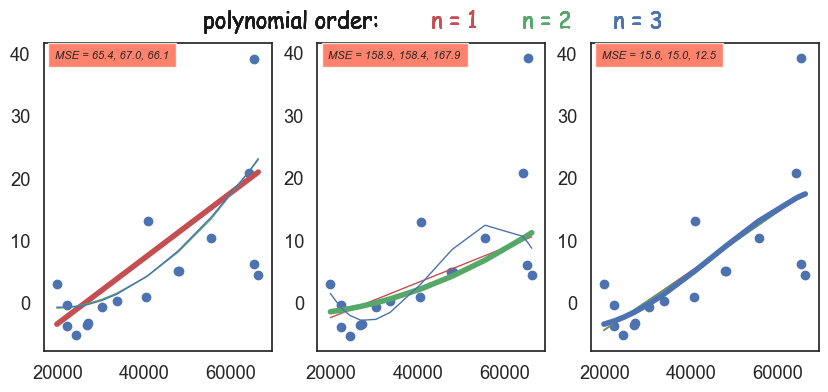

In [55]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break



In [56]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))



In [57]:


#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))



Max possible number of folds: 16 



ValueError: 'mean_squared_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [58]:
fit2.train(pol_order = 2, nb_folds = nb_folds)


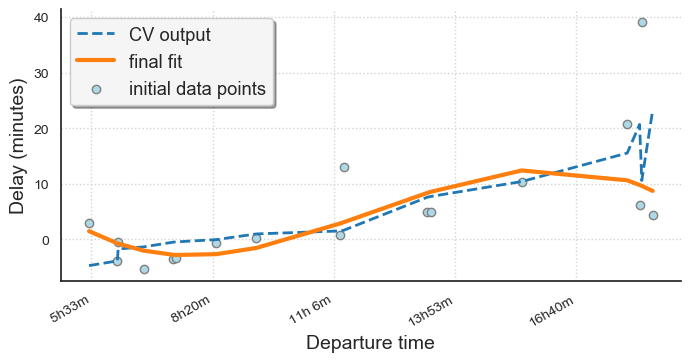

In [59]:

fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);



In [60]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score



68.7901585899033

In [61]:

test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)



In [62]:
score = metrics.mean_squared_error(fit.result, Y_test)
score


68.40915317418637

In [63]:
'Ecart = {:.2f} min'.format(np.sqrt(score))


'Ecart = 8.27 min'

In [64]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df



In [65]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape




(1831, 3)

In [66]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]



[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [67]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)


(1831, 82) (1831, 1)


In [68]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))



MSE = 53.71073451282654


In [69]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)




'5.30%'

AttributeError: module 'seaborn' has no attribute 'plt'

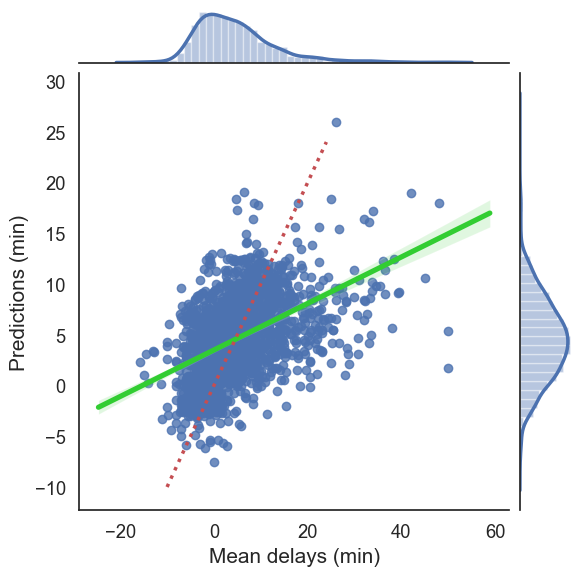

In [71]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()




In [72]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


In [73]:
X_train.shape


(1281, 82)

In [74]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)


Mean squared error =  48.76725646631356


In [76]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", round(score, 2))


Mean squared error =  298508.13


In [77]:

somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))


164048491.5 -12782.1 26.0
94174.8 300.7 -6.2


In [78]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)


Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [81]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ",round(score,2))


Mean squared error =  56.72


In [82]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))



n=1 alpha=0 , MSE = 55.891
n=1 alpha=2 , MSE = 55.426
n=1 alpha=4 , MSE = 55.698
n=1 alpha=6 , MSE = 56.218
n=1 alpha=8 , MSE = 56.809
n=1 alpha=10 , MSE = 57.399
n=1 alpha=12 , MSE = 57.959
n=1 alpha=14 , MSE = 58.481
n=1 alpha=16 , MSE = 58.961
n=1 alpha=18 , MSE = 59.401
n=2 alpha=0 , MSE = 151.03
n=2 alpha=2 , MSE = 56.918
n=2 alpha=4 , MSE = 56.633
n=2 alpha=6 , MSE = 56.614
n=2 alpha=8 , MSE = 56.694
n=2 alpha=10 , MSE = 56.828
n=2 alpha=12 , MSE = 56.995
n=2 alpha=14 , MSE = 57.183
n=2 alpha=16 , MSE = 57.382
n=2 alpha=18 , MSE = 57.588


In [83]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)


54.13739796447629


In [84]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)


In [85]:

label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)


In [86]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)


'MSE = 60.67'

In [87]:
'Ecart = {:.2f} min'.format(np.sqrt(score))


'Ecart = 7.79 min'

In [88]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3


In [89]:
df3 = create_df(df, carrier)    
df3[:5]


,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,2.133333,2.800000
1,300,17700,LAX,5.500000,3.750000
2,600,28200,LAX,-6.000000,3.250000
3,1200,29040,LAX,-4.117647,2.823529
4,1200,29100,LAX,0.800000,3.600000


In [91]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)



In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


In [93]:

score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))



n=1 alpha=0.0 , MSE = 77.215
n=1 alpha=0.2 , MSE = 76.509
n=1 alpha=0.4 , MSE = 76.608
n=1 alpha=0.6 , MSE = 77.048
n=1 alpha=0.8 , MSE = 77.64
n=1 alpha=1.0 , MSE = 78.29
n=1 alpha=1.2 , MSE = 78.953
n=1 alpha=1.4 , MSE = 79.605
n=1 alpha=1.6 , MSE = 80.232
n=1 alpha=1.8 , MSE = 80.831
n=2 alpha=0.0 , MSE = 1.1669e+04
n=2 alpha=0.2 , MSE = 78.697
n=2 alpha=0.4 , MSE = 78.192
n=2 alpha=0.6 , MSE = 77.962
n=2 alpha=0.8 , MSE = 77.845
n=2 alpha=1.0 , MSE = 77.8
n=2 alpha=1.2 , MSE = 77.807
n=2 alpha=1.4 , MSE = 77.853
n=2 alpha=1.6 , MSE = 77.93
n=2 alpha=1.8 , MSE = 78.032


In [94]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)



84.7484221305609


In [95]:
df3 = create_df(df_test, carrier)    
df3[:5]


,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,-4.000,3.25
1,1200,29040,LAX,5.125,3.25
2,1800,20340,SFO,-6.750,3.25
3,2700,29340,LAS,-4.500,3.25
4,3900,31800,LAX,-4.875,3.25


In [96]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['heure_depart', 'heure_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)



In [97]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))


MSE = 74.95


In [98]:
'Ecart = {:.2f} min'.format(np.sqrt(score))


'Ecart = 8.66 min'

In [99]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))




ecarts > 15 minutes: 4.478%


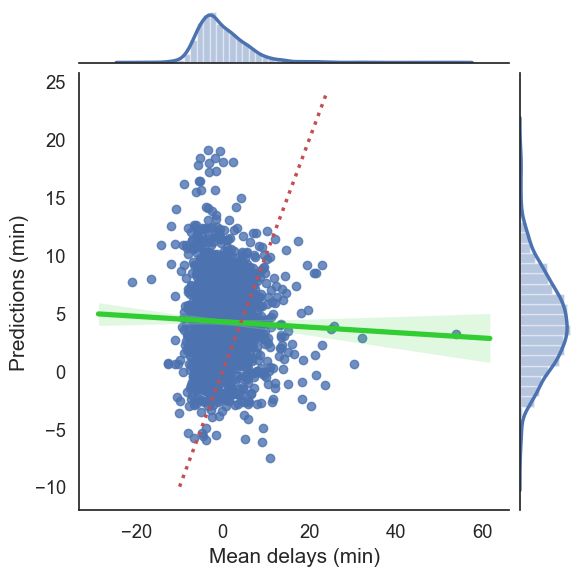

In [101]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
# sns.plt.show()


MSE = 76.91091309425835


AttributeError: module 'seaborn' has no attribute 'plt'

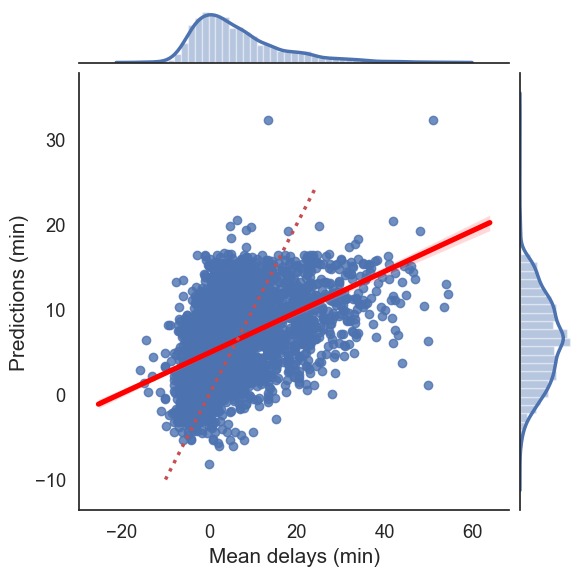

In [103]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'red'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()
